Using device: cuda
Detected total pairs: 3929

--- Training UNet ---
Epoch 1/50 | Model: UNet | Train Loss: 1.0396 | Val Loss: 0.9421 | Val Dice: 0.1050 | Val IoU: 0.0587
Epoch 2/50 | Model: UNet | Train Loss: 0.7688 | Val Loss: 0.7319 | Val Dice: 0.3332 | Val IoU: 0.2177
Epoch 3/50 | Model: UNet | Train Loss: 0.5929 | Val Loss: 0.6272 | Val Dice: 0.4224 | Val IoU: 0.2926
Epoch 4/50 | Model: UNet | Train Loss: 0.5092 | Val Loss: 0.7012 | Val Dice: 0.3430 | Val IoU: 0.2390
Epoch 5/50 | Model: UNet | Train Loss: 0.4432 | Val Loss: 0.4737 | Val Dice: 0.5533 | Val IoU: 0.4245
Epoch 6/50 | Model: UNet | Train Loss: 0.3877 | Val Loss: 0.4200 | Val Dice: 0.6042 | Val IoU: 0.4806
Epoch 7/50 | Model: UNet | Train Loss: 0.3514 | Val Loss: 0.3444 | Val Dice: 0.6759 | Val IoU: 0.5525
Epoch 8/50 | Model: UNet | Train Loss: 0.3213 | Val Loss: 0.3219 | Val Dice: 0.6948 | Val IoU: 0.5792
Epoch 9/50 | Model: UNet | Train Loss: 0.3182 | Val Loss: 0.3498 | Val Dice: 0.6726 | Val IoU: 0.5495
Epoch 10/50 |

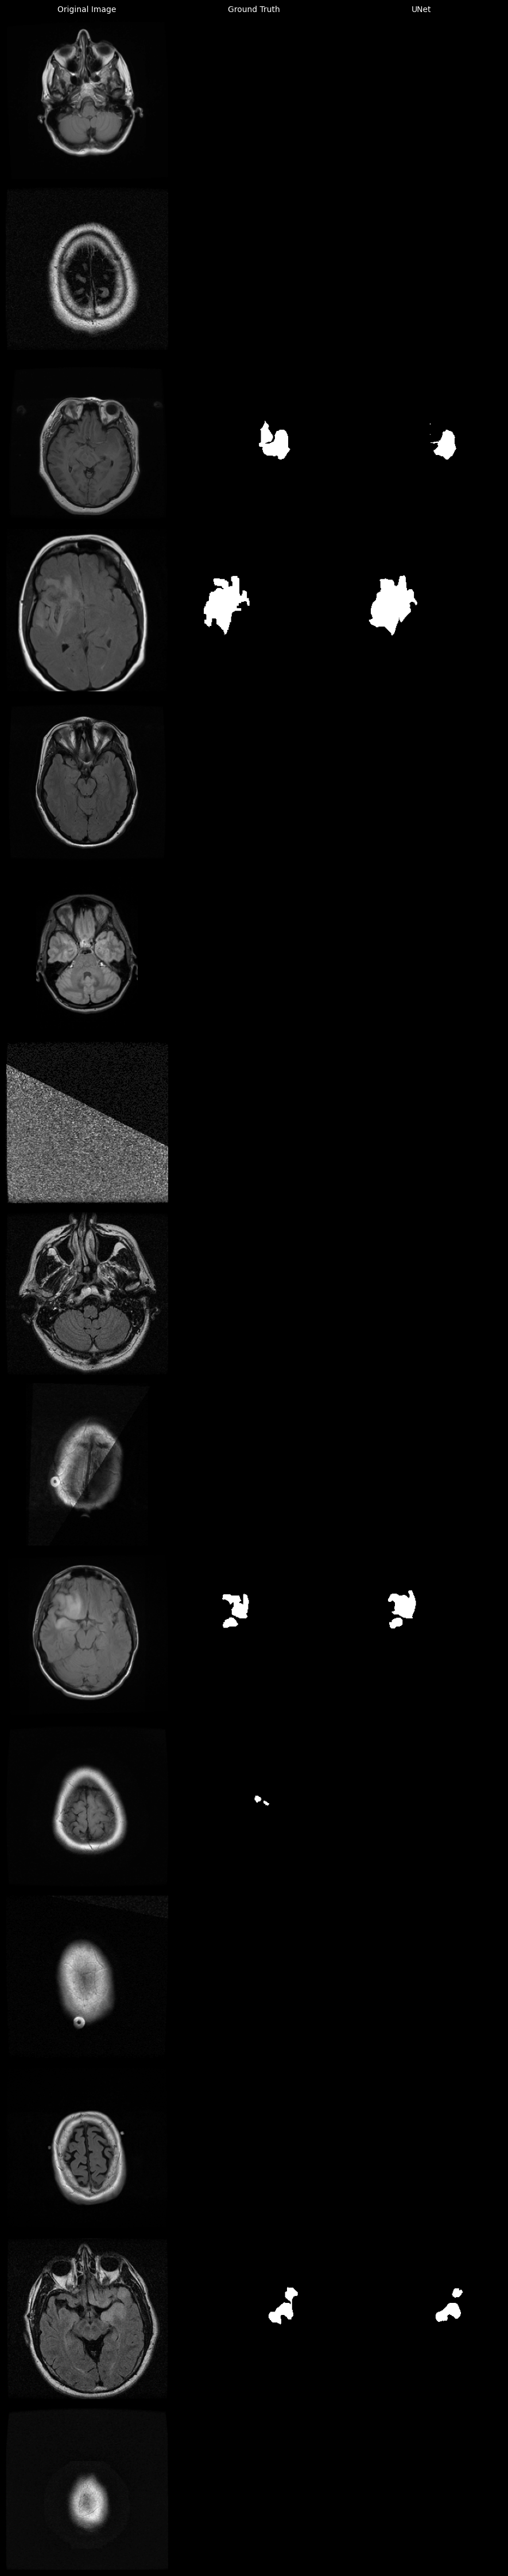

In [1]:
import os
import csv
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Check if CUDA is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ==============================================================================
# 1. Dataset Class (for actual LGG data)
# ==============================================================================
def find_lgg_pairs(root: str):
    root = Path(root)
    pairs = []
    for f in root.rglob("*.tif"):
        if f.stem.endswith("_mask"):
            continue
        mask_path = f.with_name(f.stem + "_mask.tif")
        if mask_path.exists():
            pairs.append((str(f), str(mask_path)))
    return pairs

class LGGSegmentationDataset(Dataset):
    def __init__(self, pairs, img_size=256):
        self.pairs = pairs
        self.img_size = img_size

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_p, mask_p = self.pairs[idx]
        img = Image.open(img_p).convert('L')
        mask = Image.open(mask_p).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.BILINEAR)
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)
        img = np.array(img, dtype=np.float32)[None, ...]
        img = (img - img.mean()) / (img.std() + 1e-8)
        mask = (np.array(mask) > 127).astype(np.uint8)[None, ...]
        
        return torch.from_numpy(img), torch.from_numpy(mask).float()

# ==============================================================================
# 2. Helper Functions
# ==============================================================================
def dice_coeff(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    union = preds_flat.sum() + targets_flat.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def iou_coeff(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    union = preds_flat.sum() + targets_flat.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1e-6):
        inputs_sigmoided = F.sigmoid(inputs)
        
        inputs_flat = inputs_sigmoided.view(-1)
        targets_flat = targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        
        bce = self.bce_loss(inputs, targets)
        dice_bce = bce + dice_loss
        return dice_bce

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_inference_time(model, dummy_input, device, num_warmups=10, num_runs=100):
    model.eval()
    dummy_input = dummy_input.to(device).float()
    with torch.no_grad():
        for _ in range(num_warmups):
            _ = model(dummy_input)
    if device == "cuda":
        torch.cuda.synchronize()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)
    if device == "cuda":
        torch.cuda.synchronize()
    end_time = time.time()
    avg_time_ms = ((end_time - start_time) / num_runs) * 1000
    return avg_time_ms

def visualize_predictions(models, val_dataset, device, num_samples=3, first_n=None):
    """
    If first_n is provided, visualize the first `first_n` images from val_dataset (deterministic).
    Otherwise, sample `num_samples` random images from val_dataset.
    """
    plt.style.use('dark_background')

    if first_n is not None:
        indices = list(range(min(first_n, len(val_dataset))))
    else:
        indices = random.sample(range(len(val_dataset)), min(num_samples, len(val_dataset)))

    num_images = len(indices)
    num_cols = len(models) + 2  # original + ground truth + predictions...
    
    # layout: rows = num_images, cols = num_cols
    fig, axes = plt.subplots(num_images, num_cols, figsize=(3 * num_cols, 3 * num_images))
    
    # normalize axes shape (when num_images==1 or only one model)
    if num_images == 1:
        axes = axes[None, :]  # make it 2D: (1, num_cols)
    for i in range(num_images):
        # Titles only on first row
        if i == 0:
            axes[i, 0].set_title("Original Image", fontsize=10)
            axes[i, 1].set_title("Ground Truth", fontsize=10)
            for j, name in enumerate(models.keys()):
                axes[i, j+2].set_title(name, fontsize=10)

    with torch.no_grad():
        for row_idx, idx in enumerate(indices):
            image, mask = val_dataset[idx]
            image, mask = image.to(device), mask.to(device)
            
            image_vis = image.cpu().squeeze().numpy()
            mask_vis = mask.cpu().squeeze().numpy()
            
            axes[row_idx, 0].imshow(image_vis, cmap='gray')
            axes[row_idx, 0].axis('off')
            axes[row_idx, 1].imshow(mask_vis, cmap='gray')
            axes[row_idx, 1].axis('off')
            
            for j, (name, model) in enumerate(models.items()):
                model.eval()
                output = model(image.unsqueeze(0))
                predicted_mask = (torch.sigmoid(output) > 0.5).float().cpu().squeeze().numpy()
                axes[row_idx, j+2].imshow(predicted_mask, cmap='gray')
                axes[row_idx, j+2].axis('off')

    plt.tight_layout()
    out_path = "predictions_first_n.png" if first_n is not None else "predictions.png"
    plt.savefig(out_path, dpi=300)
    print(f"\nVisualizations saved to {out_path}")

def print_comparison_table(results):
    print("\n" + "="*120)
    print("Final Model Comparison")
    print("="*120)
    headers = ["Model", "Parameters (M)", "Inference Time (ms)", "Total Time (s)", "Avg. Time/Epoch (s)", "Best Val Dice", "Best Val IoU"]
    print(f"{headers[0]:<20} {headers[1]:<20} {headers[2]:<20} {headers[3]:<20} {headers[4]:<20} {headers[5]:<20} {headers[6]:<20}")
    print("-"*120)
    for result in results:
        best_dice_index = np.argmax(result['history']['val_dice'])
        best_dice_score = result['history']['val_dice'][best_dice_index]
        best_iou_score = result['history']['val_iou'][best_dice_index]
        
        print(f"{result['model']:<20} {result['params_M']:.2f}{'':<18} {result['inference_time']:.2f}{'':<18} {result['total_time']:.2f}{'':<18} {result['avg_time_per_epoch']:.2f}{'':<18} {best_dice_score:.4f}{'':<16} {best_iou_score:.4f}{'':<16}")
    print("="*120)


# ==============================================================================
# 3. Model Definitions
# ==============================================================================

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# UNet
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Encoder
        self.conv1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        # Bottleneck
        self.conv_bottleneck = ConvBlock(512, 1024)
        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.conv5 = ConvBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.conv6 = ConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv7 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv8 = ConvBlock(128, 64)
        self.conv_out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        # Encoder
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        # Bottleneck
        cb = self.conv_bottleneck(p4)
        # Decoder
        u4 = self.up4(cb)
        u4 = torch.cat([u4, c4], dim=1)
        c5 = self.conv5(u4)
        u3 = self.up3(c5)
        u3 = torch.cat([u3, c3], dim=1)
        c6 = self.conv6(u3)
        u2 = self.up2(c6)
        u2 = torch.cat([u2, c2], dim=1)
        c7 = self.conv7(u2)
        u1 = self.up1(c7)
        u1 = torch.cat([u1, c1], dim=1)
        c8 = self.conv8(u1)
        output = self.conv_out(c8)
        return output

# ==============================================================================
# 4. Training and Evaluation Loop
# ==============================================================================
def train_and_validate_model(model_name, model, train_loader, val_loader, epochs, device):
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    loss_fn = DiceBCELoss()
    model.to(device)
    
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device).float(), masks.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device).float(), masks.to(device).float()
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()
                
                dice = dice_coeff(outputs, masks)
                iou = iou_coeff(outputs, masks)
                val_dice += dice.item()
                val_iou += iou.item()
        
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        
        print(f"Epoch {epoch+1}/{epochs} | Model: {model_name} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")
            
    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_epoch = total_time / epochs
    
    best_dice_index = np.argmax(history['val_dice'])
    
    best_epoch_metrics = {
        'best_val_dice': history['val_dice'][best_dice_index],
        'best_val_iou': history['val_iou'][best_dice_index],
        'avg_time_per_epoch': avg_time_per_epoch,
        'total_time': total_time
    }
            
    return history, best_epoch_metrics, count_params(model)


if __name__ == "__main__":
    DATA_ROOT = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"
    if not os.path.exists(DATA_ROOT):
        print(f"Dataset not found at {DATA_ROOT}. Please upload the dataset to this path.")
    else:
        pairs = find_lgg_pairs(DATA_ROOT)
        print("Detected total pairs:", len(pairs))

        # --- Use the full dataset for training/validation (no slicing to 15) ---
        random.shuffle(pairs)

        split = int(0.8 * len(pairs))
        train_pairs, val_pairs = pairs[:split], pairs[split:]
        train_dataset, val_dataset = LGGSegmentationDataset(train_pairs), LGGSegmentationDataset(val_pairs)
        
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    
        # <-- Running UNet here -->
        models = {
            "UNet": UNet(in_channels=1, out_channels=1),
        }
    
        results = []
        dummy_input = torch.randn(1, 1, 256, 256)
    
        for name, model in models.items():
            print(f"\n--- Training {name} ---")
            
            # Move model and dummy_input to the correct device
            model.to(DEVICE)
            dummy_input = dummy_input.to(DEVICE).float()
            
            param_count = count_params(model)
            inference_time = measure_inference_time(model, dummy_input, DEVICE)
            history, best_metrics, _ = train_and_validate_model(name, model, train_loader, val_loader, 50, DEVICE)
            
            results.append({
                "model": name,
                "params_M": param_count / 1e6,
                "inference_time": inference_time,
                "total_time": best_metrics['total_time'],
                "avg_time_per_epoch": best_metrics['avg_time_per_epoch'],
                "best_val_dice": best_metrics['best_val_dice'],
                "best_val_iou": best_metrics['best_val_iou'],
                "history": history
            })
    
        csv_file = "results.csv"
        with open(csv_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["model", "epoch", "train_loss", "val_loss", "val_dice", "val_iou"])
            for result in results:
                for i in range(len(result['history']['val_dice'])):
                    writer.writerow([
                        result['model'],
                        i + 1,
                        result['history']['train_loss'][i],
                        result['history']['val_loss'][i],
                        result['history']['val_dice'][i],
                        result['history']['val_iou'][i]
                    ])
        print(f"\nResults saved to {csv_file}")
        
        # <-- VISUALIZE only the first 15 images from the validation dataset (deterministic) -->
        visualize_predictions(models, val_dataset, DEVICE, first_n=15)
        print_comparison_table(results)
